# Proximal policy optimization

One drawback of trust region policy optimization is that it is difficult to implement. In 2017, Schulman et al. proposed a variant of TRPO—the proximal policy optimization algorithm (PPO). Unlike TRPO, which solves the following optimization problem 

$$
\max_{\theta}\;\mathbb{E}\bigg[\frac{\pi_{\theta}(\mathbf{a}_t|\mathbf{s}_t)}{\pi_{\theta_{\text{old}}}(\mathbf{a}_t|\mathbf{s}_t)}A_t\bigg]\hspace{5mm}
 \text{subject to} \hspace{5mm}\mathbb{E}_{\mathbf{s}\sim \rho}[\mathcal{D}_{KL}(\pi_{\theta}(\cdot|\mathbf{s}_t))||\pi_{\theta_{\text{old}}}(\cdot|\mathbf{s}_t))] \leq \delta
$$

Instead of following the KL-divergence hard constraint, the proximal policy algorithm considers a soft constraint 

$$\max_{\theta}\;\mathbb{E}\bigg[\frac{\pi_{\theta}(\mathbf{a}_t|\mathbf{s}_t)}{\pi_{\theta_{\text{old}}}(\mathbf{a}_t|\mathbf{s}_t)}A_t-\beta \mathcal{D}_{KL}(\pi_{\theta}(\cdot|\mathbf{s}_t))||\pi_{\theta_{\text{old}}}(\cdot|\mathbf{s}_t))\bigg]$$

One problem with this approach is the need to tune $\beta$. However, it is hard to find a single value of $\beta$ that performs well across different problems. To address this, Schulman et al proposed the clipped surrogate objective. Let 

$$r_t(\theta) = \frac{\pi_{\theta}(\mathbf{a}_t|\mathbf{s}_t)}{\pi_{\theta_{\text{old}}}(\mathbf{a}_t|\mathbf{s}_t)}$$

And consider the objective 

$$\mathcal{L}_{CLIP}(\theta) = \mathbb{E}\bigg[\min\{r_t(\theta)A_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)A_t\}\bigg]$$

Where $\epsilon$ is some hyperparameter. Intuitively, we prevent $\pi_{\theta}$ to be far way from $\pi_{\theta_{old}}$ by clipping the ratio back to $(1-\epsilon, 1+\epsilon)$. 

## PPO Implementation

For the policy and value function, we copied directly from our TRPO implementation. For the advantage, we again uses generalized advantage estimation.

In [ ]:
!pip -q install pybullet
!pip -q install stable-baselines3[extra]
!pip -q install pyvirtualdisplay
!apt-get install -y xvfb

import gym
import pybullet_envs
import matplotlib.pyplot as plt
import pyvirtualdisplay
import imageio
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as utils
from torch.utils.data import Dataset, DataLoader

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(Policy, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.net = SimpleNeuralNetwork(in_dim=state_dim, hidden_dim=hidden_dim, out_dim=action_dim, final_layer="Softmax", n_layers=1)

    def forward(self, obs):
        return self.net(obs)

    def select_action(self, state):
        state = torch.tensor(state).float().to(DEVICE)
        action_dist = self.net(state)
        action_dist = torch.distributions.Categorical(probs=action_dist)
        action = action_dist.sample()
        return action

    def get_action_log_prob(self, state, action):
        state = torch.tensor(state).float().to(DEVICE)
        action_dist = self.net(state)
        action_dist = torch.distributions.Categorical(probs=action_dist)
        action_log_prob = action_dist.log_prob(action)
        return action_log_prob

class Value(nn.Module):
    def __init__(self, state_dim, hidden_dim=128):
        super(Value, self).__init__()
        self.state_dim = state_dim
        self.net = SimpleNeuralNetwork(in_dim=state_dim, hidden_dim=hidden_dim, out_dim=action_dim, n_layers=1)

    def forward(self, state):
        return self.net(state)

In [ ]:
class PPOAgent(Agent):
    """
    Implementation of proximal policy agent
    """
    def __init__(self, env, state_dim, action_dim, hidden_dim, lr, eps, device="cpu"):
        self.env = env
        self.policy = Policy(state_dim, action_dim, hidden_dim).to(device)
        self.policy_old = Policy(state_dim, action_dim, hidden_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.value = Value(state_dim, hidden_dim).to(device)

        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.value_optimizer = optim.Adam(self.value.parameters(), lr=lr)
        self.scheduler = optim.lr_scheduler.StepLR(self.policy_optimizer, step_size=500, gamma=0.5)
        self.eps = eps
        self.device = device

    def learn_episode(self, batch_size, max_steps=10000, gamma=1, lambda_=1, normalize=True):
        self.policy.train()
        episode_loss = 0.0
        episode_reward = 0.0
        for _ in range(batch_size):
            states, actions, rewards, dones = self.sample_trajectory(gamma=gamma, max_steps=max_steps)

            ## 1. Update critic
            with torch.no_grad():
                target = rewards + gamma * (1 - dones) * self.value(states[1:])
            value = self.value(states[:-1])
            value_loss = nn.MSELoss()(target, value)
            self.value_optimizer.zero_grad()
            value_loss.backward()
            utils.clip_grad_norm_(self.value.parameters(), 0.5)
            self.value_optimizer.step()

            ## 2. Update policy
            advantage = self.estimate_advantage(rewards, self.value(states[:-1]), gamma=gamma, lambda_=lambda_, normalize=normalize)
            old_log_probs = self.policy_old.get_action_log_prob(states[:-1], actions).detach()
            new_log_probs = self.policy.get_action_log_prob(states[:-1], actions)
            ratio = torch.exp(new_log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            policy_loss = -torch.min(surr1, surr2).mean()
            self.policy_optimizer.zero_grad()
            policy_loss.backward()
            utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            self.policy_optimizer.step()

            ## 4. Update old policy
            self.policy_old.load_state_dict(self.policy.state_dict())
            episode_reward += rewards.sum().item() / batch_size
            episode_loss = (policy_loss.item() + value_loss.item()) / batch_size
        return episode_loss, episode_reward

    def estimate_advantage(self, rewards, values, gamma=1, lambda_=1, normalize=True):
        with torch.no_grad():
            advantages = []
            advantage = 0
            next_value = 0
            for reward, value in zip(reversed(rewards), reversed(values)):
                delta = reward + gamma * next_value - value
                advantage = delta + gamma * lambda_ * advantage
                advantages.insert(0, advantage)
                next_value = value
            advantages = torch.tensor(advantages).float().to(self.device)
            if normalize:
                advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        return advantages

We trained five PPO agents on the CartPole task with different values of $\epsilon$. All agents were trained for $2000$ epochs with a batch size of $1$. The results are shown below. Notably, $\epsilon$ values that were either too large or too small did not perform well. In our experiments, setting $\epsilon = 0.1$ yielded the best results.

In [ ]:
env = gym.make('CartPoleBulletEnv-v1')
agent = PPOAgent(env, 4, 2, 128, 1e-3, eps=0.15)
history = agent.learn(2000, batch_size=1, print_every=100)

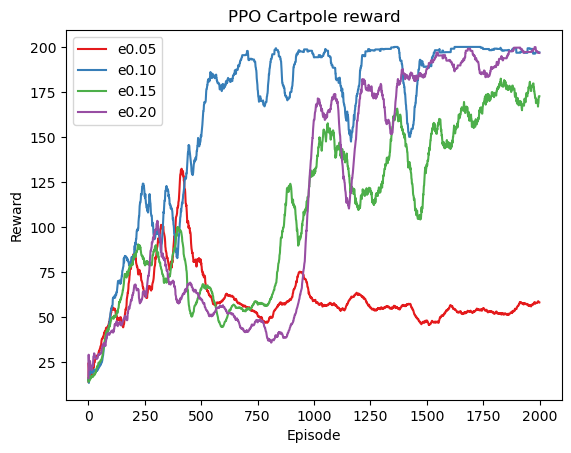

In [2]:
import numpy as np
import matplotlib.pyplot as plt

rewards = [np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/PolicyGradient/ppo/e005_reward.npy"),
           np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/PolicyGradient/ppo/e010_reward.npy"),
           np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/PolicyGradient/ppo/e015_reward.npy"),
           np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/PolicyGradient/ppo/e020_reward.npy"),
           ]

names = ["e0.05", "e0.10", "e0.15", "e0.20"]
colors = np.load("colors.npy")

def smooth(rewards, l):
    smoothed_rewards = []
    for i in range(len(rewards)):
        start_index = max(0, i - l + 1)
        smoothed_rewards.append(np.mean(rewards[start_index:i + 1]))
    return smoothed_rewards

for i, reward in enumerate(rewards):
    plt.plot(smooth(reward, 50), c=colors[i], label=names[i])
plt.title("PPO Cartpole reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

<span style="font-size:20px;"><strong>Citations</strong></span>

[1] https://arxiv.org/pdf/1707.06347